# **Hello Pycaret**

## **Librerias**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pd.options.display.max_columns = False

In [3]:
from datetime import datetime, timedelta
import winsound

In [43]:
from pycaret.classification import *

## **Datos**

### **Exploración Inicial**

In [12]:
df = pd.read_csv('https://raw.githubusercontent.com/srees1988/predict-churn-py/main/customer_churn_data.csv')

In [33]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [27]:
df['TotalCharges'].replace(' ', np.nan, inplace=True)
df['TotalCharges'] = df['TotalCharges'].astype('float64')

In [36]:
df.sample()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
5164,6135-OZQVA,Female,0,No,No,7,Yes,Yes,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,53.65,404.35,No


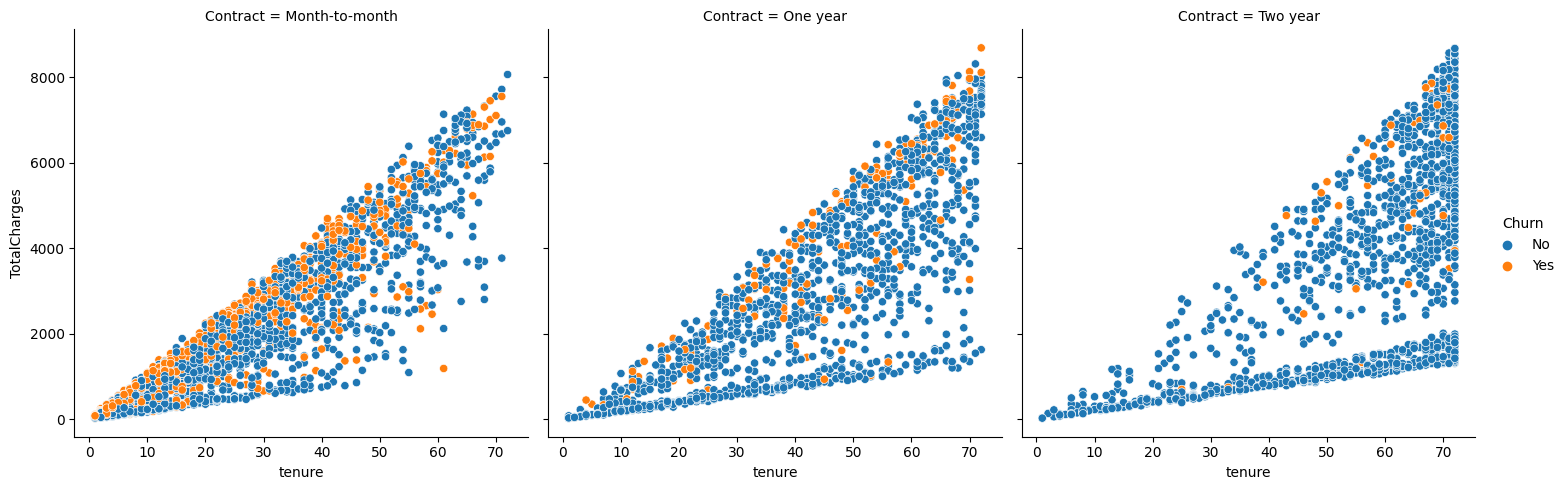

In [42]:
sns.relplot(
   	data=df, 
    x='tenure', 
    y='TotalCharges', 
    col='Contract',
    hue='Churn'
)

plt.show()

### **Preparación de los Datos**

In [47]:
setup = setup(
    df,
    target = 'Churn',
    ignore_features=['customerID']
)

,Description,Value
0,session_id,6949
1,Target,Churn
2,Target Type,Binary
3,Label Encoded,"No: 0, Yes: 1"
4,Original Data,"(7043, 21)"
5,Missing Values,True
6,Numeric Features,3
7,Categorical Features,16
8,Ordinal Features,False
9,High Cardinality Features,False


### **Entrenamiento del Modelo**

In [48]:
%%time
best_model = compare_models(sort='AUC')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ada,Ada Boost Classifier,0.8063,0.8477,0.5520,0.6662,0.6028,0.4764,0.4807,0.3120
gbc,Gradient Boosting Classifier,0.8018,0.8470,0.5383,0.6582,0.5915,0.4625,0.4671,0.6970
lr,Logistic Regression,0.8026,0.8442,0.5444,0.6581,0.5951,0.4662,0.4704,1.4610
lda,Linear Discriminant Analysis,0.7996,0.8393,0.5642,0.6428,0.6002,0.4674,0.4696,0.0500
lightgbm,Light Gradient Boosting Machine,0.7970,0.8327,0.5384,0.6427,0.5857,0.4527,0.4559,0.1720
nb,Naive Bayes,0.7505,0.8319,0.7764,0.5225,0.6243,0.4482,0.4682,0.0220
rf,Random Forest Classifier,0.7876,0.8234,0.4912,0.6312,0.5513,0.4154,0.4216,0.6200
et,Extra Trees Classifier,0.7744,0.7943,0.4874,0.5942,0.5350,0.3882,0.3918,0.5910
knn,K Neighbors Classifier,0.7586,0.7437,0.4266,0.5635,0.4843,0.3310,0.3371,0.0730
dt,Decision Tree Classifier,0.7359,0.6652,0.5101,0.5056,0.5075,0.3272,0.3274,0.0690


CPU times: total: 11 s
Wall time: 57.3 s


In [49]:
print(best_model)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=6949)


### **Ajuste de HiperParametros**

In [50]:
%%time
tuned_best_model = tune_model(best_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8012,0.8581,0.5758,0.6441,0.6080,0.4754,0.4767
1,0.7972,0.8381,0.5227,0.6509,0.5798,0.4482,0.4529
2,0.8012,0.8240,0.5227,0.6635,0.5847,0.4565,0.4621
3,0.8458,0.8874,0.6136,0.7642,0.6807,0.5807,0.5867
4,0.8093,0.8567,0.6136,0.6532,0.6328,0.5042,0.5047
5,0.8053,0.8537,0.5649,0.6549,0.6066,0.4781,0.4804
6,0.7890,0.8197,0.4580,0.6452,0.5357,0.4043,0.4142
7,0.7850,0.8239,0.5267,0.6106,0.5656,0.4237,0.4258
8,0.8073,0.8235,0.5267,0.6765,0.5923,0.4687,0.4749


CPU times: total: 7.58 s
Wall time: 1min 25s


### **Análisis del Modelo**

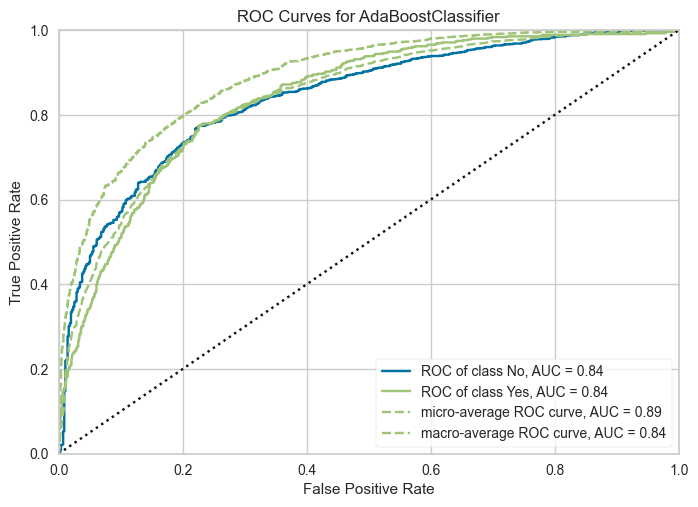

In [51]:
plot_model(tuned_best_model, plot='auc')

#### **Feature Importance**

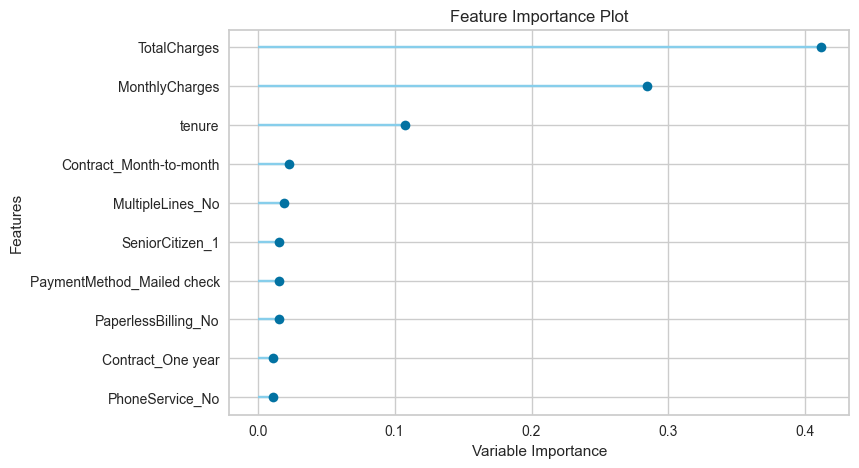

In [54]:
plot_model(tuned_best_model, plot='feature')

#### **Matriz de Confusión**

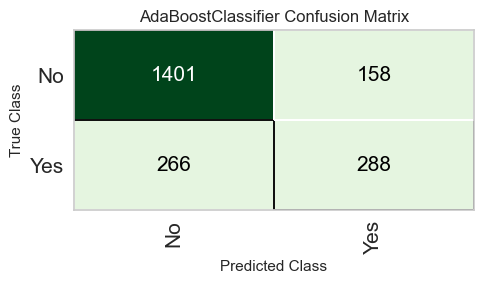

In [64]:
plt.subplots(figsize = (5, 3))
plot_model(tuned_best_model, plot='confusion_matrix')

In [72]:
# La ganancia por usuario es de 5000. Descontamos el costo de la retención (1000)
retenidos = (288 * 4000) 
# Cómo son usuarios que se van perdemos el costo de la retención (1000)
churn = (158 * -1000)

In [73]:
# El valor de nuestra ganancia es igual a
print(retenidos + churn)

994000


### **Agregando una métrica personalizada al modelo**

In [65]:
def calculate_profit(y, y_pred):
    tp = np.where((y_pred == 1) & (y == 1), (5000 - 1000), 0) 
    fp = np.where((y_pred == 1) & (y == 0), (0 - 1000), 0) 
    
    return np.sum([tp, fp])

In [66]:
add_metric('profit', 'Profit', calculate_profit)

Name                                                            Profit
Display Name                                                    Profit
Score Function       <function calculate_profit at 0x000001F70DCDBAF0>
Scorer                                   make_scorer(calculate_profit)
Target                                                            pred
Args                                                                {}
Greater is Better                                                 True
Multiclass                                                        True
Custom                                                            True
Name: profit, dtype: object

In [67]:
new_best_model = compare_models(sort='Profit')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Profit,TT (Sec)
nb,Naive Bayes,0.7505,0.8319,0.7764,0.5225,0.6243,0.4482,0.4682,314800.0000,0.0250
lda,Linear Discriminant Analysis,0.7996,0.8393,0.5642,0.6428,0.6002,0.4674,0.4696,255300.0000,0.0420
ada,Ada Boost Classifier,0.8063,0.8477,0.5520,0.6662,0.6028,0.4764,0.4807,253800.0000,0.2670
lr,Logistic Regression,0.8026,0.8442,0.5444,0.6581,0.5951,0.4662,0.4704,249000.0000,1.1220
gbc,Gradient Boosting Classifier,0.8018,0.8470,0.5383,0.6582,0.5915,0.4625,0.4671,246200.0000,0.6790
ridge,Ridge Classifier,0.8043,0.0000,0.5345,0.6674,0.5928,0.4661,0.4716,245900.0000,0.0240
lightgbm,Light Gradient Boosting Machine,0.7970,0.8327,0.5384,0.6427,0.5857,0.4527,0.4559,243800.0000,0.1310
qda,Quadratic Discriminant Analysis,0.6335,0.6642,0.7301,0.4057,0.5166,0.2639,0.2954,238800.0000,0.0310
rf,Random Forest Classifier,0.7876,0.8234,0.4912,0.6312,0.5513,0.4154,0.4216,220600.0000,0.5780
et,Extra Trees Classifier,0.7744,0.7943,0.4874,0.5942,0.5350,0.3882,0.3918,212600.0000,0.5500


#### **Matriz de Confusión**

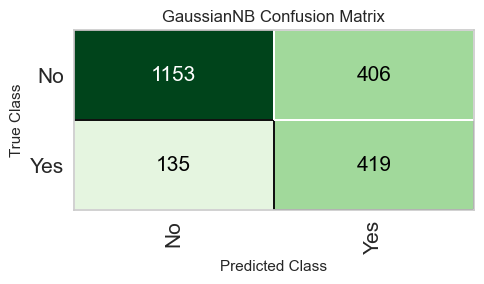

In [68]:
plt.subplots(figsize = (5, 3))
plot_model(new_best_model, plot='confusion_matrix')

In [74]:
# La ganancia por usuario es de 5000. Descontamos el costo de la retención (1000)
retenidos = (419 * 4000) 
# Cómo son usuarios que se van perdemos el costo de la retención (1000)
churn = (406 * -1000)

In [75]:
# El valor de nuestra ganancia es igual a
print(retenidos + churn)

1270000
